<a href="https://colab.research.google.com/github/hirokimituya/book_create-profitable-AI-with-Python/blob/main/ch05_02_bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2 天候による売上予測（回帰）

## 共通事前処理

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

## 5.2.4 データ読み込みからデータ確認まで

In [3]:
# ダウンロード元URL
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 公開データのダウンロードと解凍
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

--2023-03-23 09:32:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.36MB/s    in 0.2s    

2023-03-23 09:32:20 (1.36 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

  inflating: hour.csv                


In [4]:
!head -5 day.csv

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562


In [5]:
# day.csvをデータフレームに取り込み
# 日付を表す列は parse_dates で指定する
df = pd.read_csv('day.csv', parse_dates=[1])

# データ属性の確認
print(df.dtypes)

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


In [6]:
# instantは連番で予測不要なので削除
df = df.drop('instant', axis=1)

# 項目名の日本語化
columns = [
    '日付',  '季節',  '年', '月', '祝日', '曜日', '勤務日', '天気', 
    '気温', '体感温度',  '湿度', '風速',
    '臨時ユーザー利用数', '登録ユーザー利用数', '全体ユーザー利用数'
]

# 項目名を日本語に置き換え
df.columns = columns

In [7]:
# 先頭5行の確認
display(df.head())

# 最終5行の確認
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


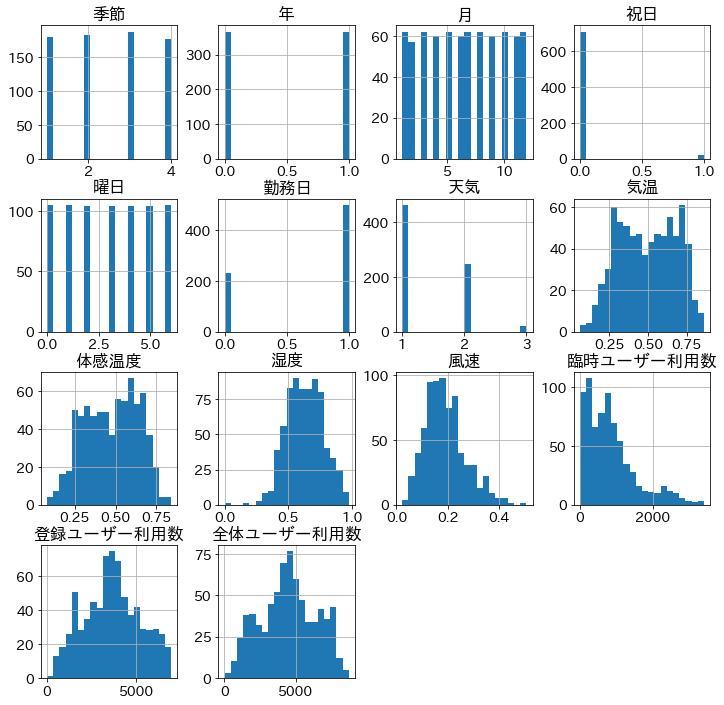

In [8]:
# 度数分布表示

# グラフのサイズ調整のためのおまじない
from pylab import rcParams
rcParams['figure.figsize'] = (12, 12)

# データフレームの数値項目でヒストグラム表示
df.hist(bins=20, column=columns[1:])
plt.show()

In [9]:
# 欠損値チェック
df.isnull().sum()

日付           0
季節           0
年            0
月            0
祝日           0
曜日           0
勤務日          0
天気           0
気温           0
体感温度         0
湿度           0
風速           0
臨時ユーザー利用数    0
登録ユーザー利用数    0
全体ユーザー利用数    0
dtype: int64

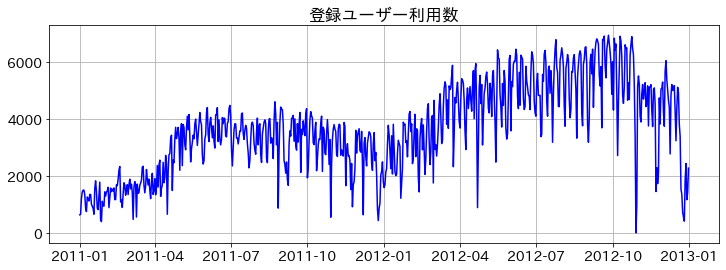

In [10]:
# 時系列グラフの描画（登録ユーザー利用数）
plt.figure(figsize=(12, 4))

# グラフ描画
plt.plot(df['日付'], df['登録ユーザー利用数'], c='b')

# 方眼表示など
plt.grid()
plt.title('登録ユーザー利用数')

# 画面出力
plt.show()

## 5.2.5 データ前処理とデータ分割

In [11]:
# x, yへの分割
x = df.drop(['日付', '臨時ユーザー利用数', '登録ユーザー利用数', '全体ユーザー利用数'], axis=1)
y = df['登録ユーザー利用数'].values

In [12]:
# 分割日 mday の設定
mday = pd.to_datetime('2012-11-1')

# 訓練用indexと検証用indexを作る
train_index = df['日付'] < mday
test_index = df['日付'] >= mday

#　入力データの分割
x_train = x[train_index]
x_test = x[test_index]

# yも同様に分割
y_train = y[train_index]
y_test = y[test_index]

# 日付データの分割（グラフ表示用）
dates_test = df['日付'][test_index]

In [13]:
# 結果確認（サイズを確認）
print(x_train.shape)
print(x_test.shape)

# 結果確認（境界値を重点的に）
display(x_train.tail())
display(x_test.head())

(670, 11)
(61, 11)


,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速
665,4,1,10,0,6,0,2,0.5300,0.5151,0.7200,0.2357
666,4,1,10,0,0,0,2,0.4775,0.4678,0.6946,0.3980
667,4,1,10,0,1,1,3,0.4400,0.4394,0.8800,0.3582
668,4,1,10,0,2,1,2,0.3182,0.3099,0.8255,0.2130
669,4,1,10,0,3,1,2,0.3575,0.3611,0.6667,0.1667


,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速
670,4,1,11,0,4,1,2,0.3658,0.3699,0.5817,0.1573
671,4,1,11,0,5,1,1,0.3550,0.3560,0.5221,0.2662
672,4,1,11,0,6,0,2,0.3433,0.3238,0.4913,0.2705
673,4,1,11,0,0,0,1,0.3258,0.3295,0.5329,0.1791
674,4,1,11,0,1,1,1,0.3192,0.3081,0.4942,0.2363


## 5.2.6 アルゴリズム選択

In [14]:
# アルゴリズム選択
# XGBRegressorを選択する
from xgboost import XGBRegressor
algorithm = XGBRegressor(objective='reg:squarederror', random_state=random_seed)

## 5.2.7 学習・予測

In [15]:
# 登録ユーザー利用数予測モデルの学習と予測

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

# 予測結果確認
print(y_pred[:5])

[4927.806  4889.2686 3571.434  3637.8308 4719.999 ]


## 5.2.8 評価

In [16]:
# 評価（登録ユーザー利用数）

# score関数の呼び出し
score = algorithm.score(x_test, y_test)

# R2値の計算
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_pred)

# 結果確認
print(f'score: {score:.4f}  r2_score: {r2_score:.4f}')

score: 0.4206  r2_score: 0.4206


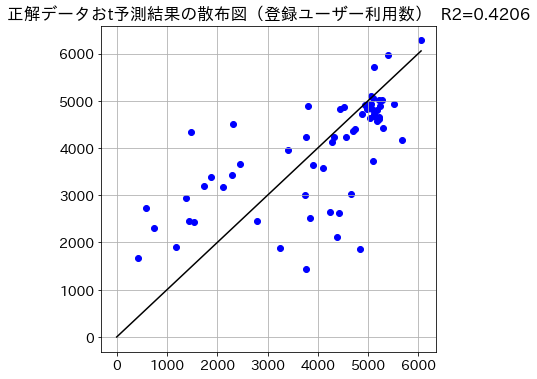

In [17]:
# 正解データと予測結果を散布図で比較（登録ユーザー利用数）
plt.figure(figsize=(6, 6))
y_max = y_test.max()
plt.plot((0, y_max), (0, y_max), c='k')
plt.scatter(y_test, y_pred, c='b')
plt.title(f'正解データおt予測結果の散布図（登録ユーザー利用数）  R2={score:.4f}')
plt.grid()
plt.show()

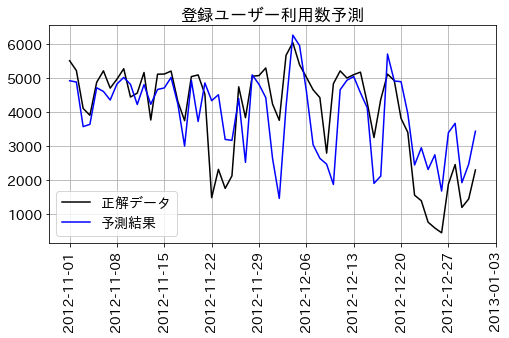

In [18]:
# 時系列グラフの描画（登録ユーザー利用数）
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# グラフ描画
ax.plot(dates_test, y_test, label='正解データ', c='k')
ax.plot(dates_test, y_pred, label='予測結果', c='b')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測')

# 画面出力
plt.show()

## 5.2.9 チューニング

In [19]:
# 項目をOne-Hotエンコーディングするための関数
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
    return df

# 項目「月」「季節」をOne-Hotエンコーディングする
x2 = x.copy()
x2 = enc(x2, '月')
x2 = enc(x2, '季節')

# 結果確認
display(x2.head())

,年,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,月_1,月_2,月_3,月_4,月_5,月_6,月_7,月_8,月_9,月_10,月_11,月_12,季節_1,季節_2,季節_3,季節_4
0,0,0,6,0,2,0.3442,0.3636,0.8058,0.1604,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,2,0.3635,0.3537,0.6961,0.2485,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,1,0.1964,0.1894,0.4373,0.2483,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,2,1,1,0.2000,0.2121,0.5904,0.1603,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,3,1,1,0.2270,0.2293,0.4370,0.1869,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## 5.2.10 重要度分析

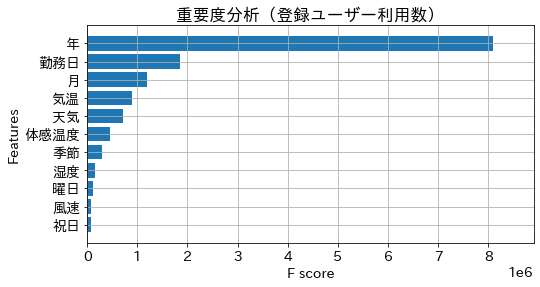

In [20]:
# 登録ユーザー利用数に対する重要度分析
import xgboost as xgb
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(algorithm, ax=ax, height=0.8,
                    importance_type='gain', show_values=False,
                    title='重要度分析（登録ユーザー利用数）')
plt.show()